In [9]:
from google.cloud import bigquery

bqclient = bigquery.Client.from_service_account_json("musa-509-75492c1cf2ae.json")

In [10]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import datashader as ds
import numpy as np

import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

from datashader.bundling import connect_edges, hammer_bundle
from datashader.colors import inferno, viridis
from datashader.utils import export_image
from datashader.utils import lnglat_to_meters

from colorcet import palette
from matplotlib import cm

In [11]:
metros = pd.read_csv("https://raw.githubusercontent.com/asrenninger/networks/master/data/metrolist.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

In [12]:
metros.head()

,metro_fips,metro_name,county_fips,county_name
0,10180,"Abilene, TX (Metropolitan Statistical Area)",48059,"Callahan, TX"
1,10180,"Abilene, TX (Metropolitan Statistical Area)",48253,"Jones, TX"
2,10180,"Abilene, TX (Metropolitan Statistical Area)",48441,"Taylor, TX"
3,10420,"Akron, OH (Metropolitan Statistical Area)",39133,"Portage, OH"
4,10420,"Akron, OH (Metropolitan Statistical Area)",39153,"Summit, OH"


In [13]:
from shapely import wkt

def get_codes(key_word):
    
    key_word_lower = key_word.lower()
    
    study = metros[metros.metro_name.str.lower().str.contains(key_word_lower)]
    codes = tuple(study.county_fips.astype('str').str.pad(fillchar="0", side='left', width=5))
    
    return codes

def get_nodes(fips):
    query = f"""
        SELECT 
            geo_id as cbg, 
            ST_X(ST_CENTROID(blockgroup_geom)) as X,
            ST_Y(ST_CENTROID(blockgroup_geom)) as Y,
        FROM `bigquery-public-data.geo_census_blockgroups.us_blockgroups_national`
        WHERE SUBSTR(lpad(geo_id, 12, '0'), 0, 5) IN {fips}
            """
    
    resp = bqclient.query(query) 
    data = resp.to_dataframe()
    
    data['cbg'] = data['cbg'].astype('int64')
    
    return data.set_index('cbg')

def get_edges(fips, month, cbgs):
    
    job_config = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("fips", "STRING", fips),
            bigquery.ScalarQueryParameter("month", "STRING", month),
        ]
    )
    
    query = f"""
        SELECT poi_cbg, home_cbg, sum(visits) as visits
        FROM (SELECT 
                lpad(CAST(poi_cbg AS STRING), 12, '0') as poi_cbg, 
                REGEXP_EXTRACT(unnested, '(.*?):') as home_cbg, 
                CAST(REGEXP_EXTRACT(unnested, ':(.*)') AS NUMERIC) as visits
              FROM `tidal-digit-291220.safegraph.2020_{month}`
              CROSS JOIN UNNEST(SPLIT(regexp_replace(REPLACE(REPLACE(visitor_home_cbgs, '{{', ''), '}}', ''), '\\"', ''))) as unnested
              WHERE SUBSTR(lpad(CAST(poi_cbg AS STRING), 12, '0'), 0, 5) IN {fips} AND visitor_home_cbgs != '{{}}')
        GROUP BY poi_cbg, home_cbg
            """
    
    resp = bqclient.query(query, job_config=job_config)
    data = resp.to_dataframe()
    
    edges = data.rename(columns={'poi_cbg': 'focal', 
                                 'home_cbg': 'target', 
                                 'visits': 'weight'})

    edges['focal'] = edges['focal'].astype('int64')
    edges['target'] = edges['target'].astype('int64')
    edges['weight'] = edges['weight'].astype('int64')

    edges = edges[edges['target'].isin(cbgs)]
    edges = edges[edges['weight']>10]
    
    return edges

def get_graph(edges, nodes, method='direct'):
    if method == 'bundled':
        print('Bundling desire lines...')
        return hammer_bundle(nodes, edges,
                             source='focal', target='target',
                             decay=0.25,
                             x='X', y='Y')
    else:
        print('Linking desire lines...')
        return connect_edges(nodes, edges,
                             source='focal', target='target',
                             x='X', y='Y')
    
def get_shape(fips):
    query = f"""
        SELECT 
            geo_id as cbg, 
            blockgroup_geom as cbg_geometry
        FROM `bigquery-public-data.geo_census_blockgroups.us_blockgroups_national`
        WHERE SUBSTR(lpad(geo_id, 12, '0'), 0, 5) IN {fips}
            """
    
    resp = bqclient.query(query) 
    data = gpd.GeoDataFrame(resp.to_dataframe(), 
                            geometry=[wkt.loads(row.cbg_geometry) for row in resp], 
                            crs="epsg:4326").drop('cbg_geometry', axis=1)
    
    return data

def get_water(fips):
    
    water = list()

    for county in fips:
        year = 2018
    
        sfips = county[:2]
        cfips = county[2:]
    
        url = f"https://www2.census.gov/geo/tiger/TIGER{year}/AREAWATER/tl_{year}_{sfips}{cfips}_areawater.zip"
    
        water.append(gpd.read_file(url))

    return gpd.GeoDataFrame(pd.concat(water, ignore_index=True))

In [33]:
codes = get_codes("miami")

In [34]:
nodes = get_nodes(codes)

In [35]:
months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]

In [36]:
edges = list()

for month in months:
        
        temp = get_edges(codes, month, nodes.index)
        temp['month'] = month
        
        edges.append(temp)

edges = pd.concat(edges, ignore_index=True)

In [37]:
shape = get_shape(codes)
water = get_water(codes)

In [38]:
def nodesplot(nodes):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.points(nodes,'X','Y',agg=None)
    spr = tf.spread(tf.shade(agg, cmap=palette['CET_L7'][20]), px=8)
    
    return spr

def edgesplot(nodes, edges):
    canvas = ds.Canvas(x_range=(nodes['X'].min(), nodes['X'].max()),
                       y_range=(nodes['Y'].min(), nodes['Y'].max()),
                       plot_height=3000, plot_width=3000)
    
    agg = canvas.line(edges, 'X','Y', agg=ds.count())
    spr = tf.shade(agg, cmap=palette['bmy'], how='eq_hist')
    
    return spr

def combiplot(nodes, edges):
    
    verts = nodesplot(nodes)
    links = edgesplot(nodes, edges)
    
    stack = tf.stack(verts, links)
    
    ready = tf.set_background(stack, '#000000')
    
    return ready.to_pil()

def plot_graphs_by_month(fig, data, nodes, month, x_range, y_range):
    
    temp = data[data['month']==month].drop('month', axis=1)
    
    graph = connect_edges(nodes, temp,
                          source='focal', target='target',
                          x='X', y='Y', weight='weight')

    img = combiplot(nodes, graph)

    plt.clf()
    ax = fig.gca()
    ax.imshow(img, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], origin='upper')
    ax.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.tight_layout()

    ax.text(
        0.05,
        0.9,
        "Origin-Destination Flows",
        color="white",
        weight='bold',
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
    
    ax.text(
        0.05,
        0.85,
        months[int(month)-1],
        color="white",
        fontsize=40,
        ha="left",
        transform=ax.transAxes,
    )
    
    shape.plot(color='None', edgecolor='#ffffff', linewidth=0.25, alpha=0.5, ax=ax)
    
    network = nx.from_pandas_edgelist(temp, 'focal', 'target', ['weight'])
    
    density.append(nx.density(network))
    
    sub = plt.axes([0.07, 0.7, 0.25, 0.1], facecolor='#000000')
    sub.step(x=np.arange(1, len(density) + 1), y=density, color='#ffffff')
    
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#000000') 
    ax.spines['right'].set_color('000000')
    ax.spines['left'].set_color('000000')
    
    plt.title('network density', weight='bold', color='#ffffff', position=(0.2, 0)) 

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype="uint8")
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return image

In [39]:
## quadrants
# [0.05, 0.2, 0.25, 0.1] bottom-left
# [0.7, 0.1, 0.25, 0.1] bottom-right

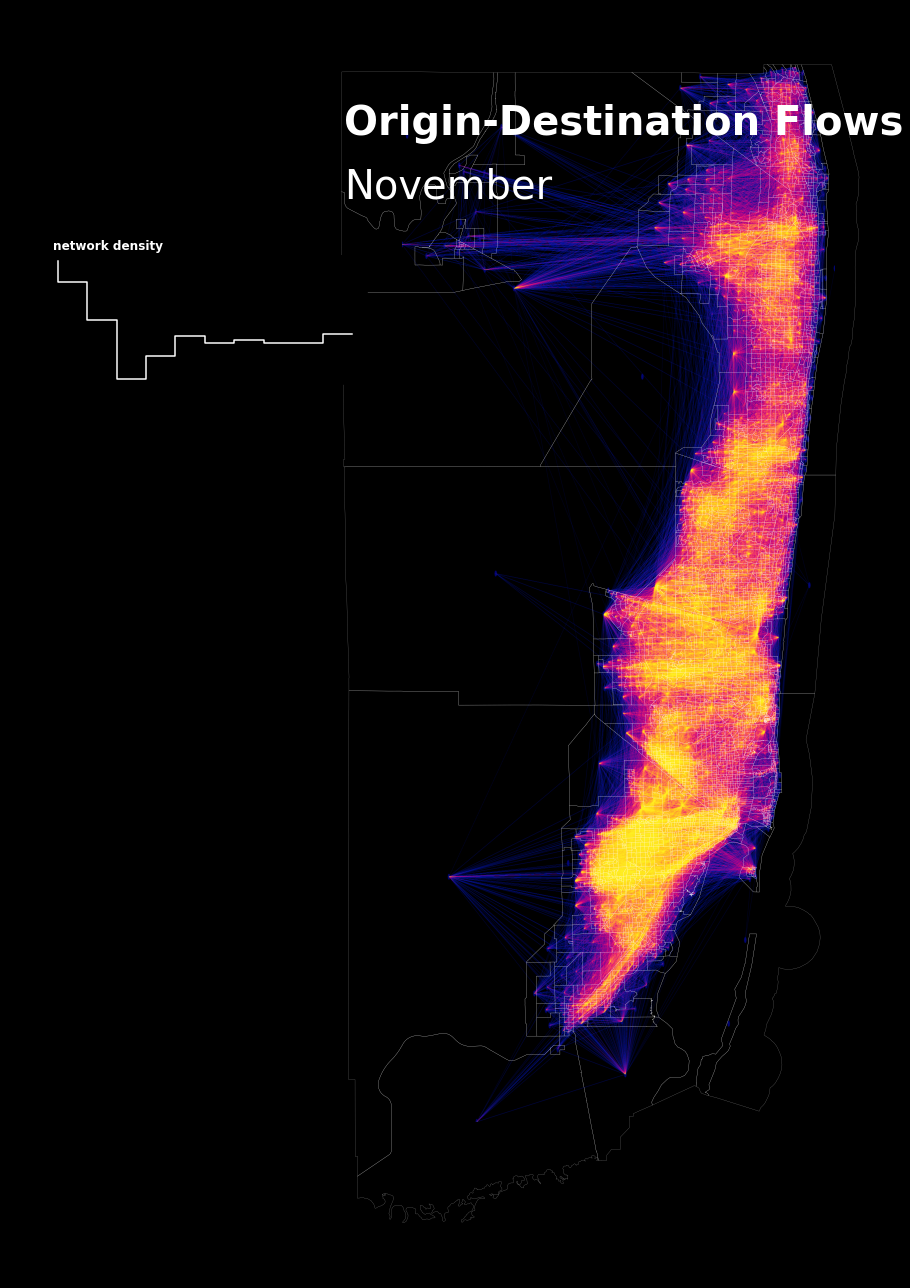

In [40]:
import imageio

bnds = [(nodes['X'].min(), nodes['X'].max()), (nodes['Y'].min(), nodes['Y'].max())]
imgs = []

density = []

fig, ax = plt.subplots(figsize=(18, 18), facecolor='black')

for period in np.sort(edges.month.unique()):
    
    img = plot_graphs_by_month(fig, edges, nodes, period, x_range=bnds[0], y_range=bnds[1])
    imgs.append(img)

imageio.mimsave('miami.gif', imgs, fps=1);

In [157]:
edges['poi_county'] = edges.target.astype('str').str.slice(stop=5)
edges['home_county'] = edges.focal.astype('str').str.slice(stop=5)

In [160]:
study = metros[metros.metro_name.str.contains("New York")]

study['county'] = study.county_fips.astype('str')

study['county_name'] = study.county_name.str.replace(", NY", "")
study['county_name'] = study.county_name.str.replace(", NJ", "")
study['county_name'] = study.county_name.str.replace(", PA", "")

study.head()

<ipython-input-160-09f23a2b4f82>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study['county'] = study.county_fips.astype('str')
<ipython-input-160-09f23a2b4f82>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  study['county_name'] = study.county_name.str.replace(", NY", "")
<ipython-input-160-09f23a2b4f82>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

,metro_fips,metro_name,county_fips,county_name,county
747,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",34003,Bergen,34003
748,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",34013,Essex,34013
749,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",34017,Hudson,34017
750,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",34019,Hunterdon,34019
751,35620,"New York-Newark-Jersey City, NY-NJ-PA (Metropo...",34023,Middlesex,34023


In [161]:
merged = edges.merge(study, left_on='poi_county', right_on='county', how='left')
merged = merged[merged['poi_county']==merged['home_county']]

In [162]:
names = merged.county_name.unique()

densities = list()

for name in names:
    
    density = []
    
    for month in months:
        
        temps = merged[(merged['county_name']==name) & (merged['month']==month)]
        graph = nx.from_pandas_edgelist(temps, 'focal', 'target', ['weight'])
    
        density.append(nx.density(graph))
        
    density = pd.DataFrame({'name': name,
                            'density': density})
    
    densities.append(density)
    
densities = pd.concat(densities, ignore_index=True)    

Text(0.5, 0.05, 'Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.')

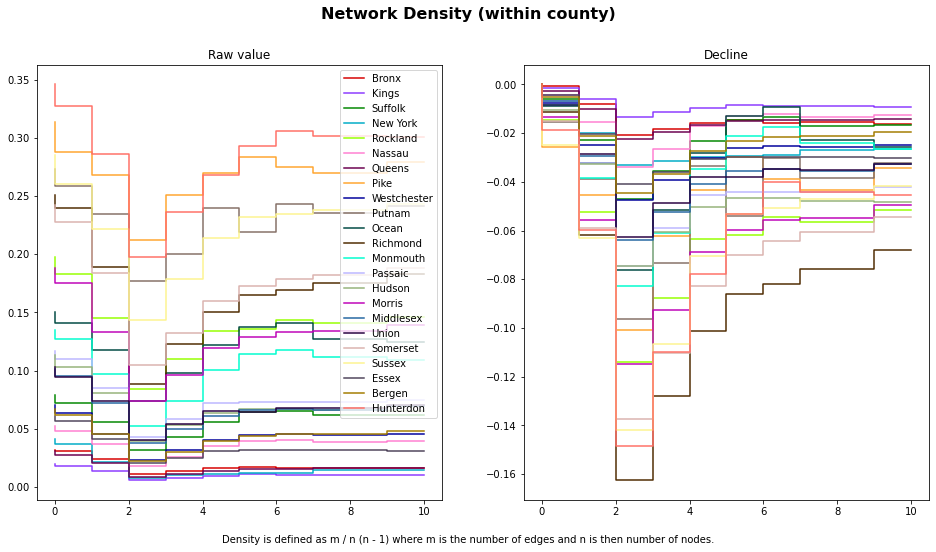

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for i in np.arange(0, len(merged.county_name.unique())):
    
    labs = merged.county_name.unique()
    fips = labs[i]
    
    temp = densities[densities['name']==fips].reset_index()
    
    axs[0].set_title('Raw value')
    axs[0].step(x=temp.index, y=temp['density'], color=palette['glasbey_bw'][i], label=labs[i])

for i in np.arange(0, len(merged.county_name.unique())):
    
    labs = merged.county_name.unique()
    fips = labs[i]
    
    temp = densities[densities['name']==fips].reset_index()
    
    axs[1].set_title('Decline')
    axs[1].step(x=temp.index, y=temp['density'] - temp['density'].max(), color=palette['glasbey_bw'][i], label=labs[i])
    
axs[0].legend()

fig.suptitle('Network Density (within county)', fontsize=16, weight='bold')
fig.text(0.5, 0.05, "Density is defined as m / n (n - 1) where m is the number of edges and n is then number of nodes.", ha='center')


In [176]:
import netcomp as nc

In [185]:
month = edges[edges['month']=='01'].drop('month', axis=1)
G1 = nx.from_pandas_edgelist(month, 'focal', 'target', ['weight'])

In [186]:
month = edges[edges['month']=='04'].drop('month', axis=1)
G2 = nx.from_pandas_edgelist(month, 'focal', 'target', ['weight'])

In [ ]:
nx.graph_edit_distance(G1,G2)